In [ ]:
import torch
import torch.nn as nn  # NN networks (CNN, RNN, losses)
import torch.optim as optim  # Aptimizers (Adam, Adadelta, Adagrad)
# Activarions func (ReLU, Sigmoid) also included in nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset  # Dataset manager
import torchvision.datasets as datasets  # Datasets
import torchvision.transforms as transforms  # Transformation to datasets
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

sns.set(rc={"figure.figsize": (13, 10)})


In [2]:
train_data = pd.read_csv("./data/train.csv").set_index("id")
valid_data = pd.read_csv("./data/test.csv").set_index("id")
datasets = [train_data, valid_data]
train_data.shape, valid_data.shape


((26570, 25), (20775, 24))

In [3]:
train_data.head()


,product_code,loading,attribute_0,attribute_1,attribute_2,attribute_3,measurement_0,measurement_1,measurement_2,measurement_3,...,measurement_9,measurement_10,measurement_11,measurement_12,measurement_13,measurement_14,measurement_15,measurement_16,measurement_17,failure
id,,,,,,,,,,,,,,,,,,,,,
0,A,80.10,material_7,material_8,9,5,7,8,4,18.040,...,10.672,15.859,17.594,15.193,15.029,NaN,13.034,14.684,764.100,0
1,A,84.89,material_7,material_8,9,5,14,3,3,18.213,...,12.448,17.947,17.915,11.755,14.732,15.425,14.395,15.631,682.057,0
2,A,82.43,material_7,material_8,9,5,12,1,5,18.057,...,12.715,15.607,NaN,13.798,16.711,18.631,14.094,17.946,663.376,0
3,A,101.07,material_7,material_8,9,5,13,2,6,17.295,...,12.471,16.346,18.377,10.020,15.250,15.562,16.154,17.172,826.282,0
4,A,188.06,material_7,material_8,9,5,9,2,8,19.346,...,10.337,17.082,19.932,12.428,16.182,12.760,13.153,16.412,579.885,0


In [4]:
TARGET = "failure"
SEED = 0
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [5]:
print(
    f"Train NAs: {train_data.isna().sum().sum()}\nTest NAs: {valid_data.isna().sum().sum()}")


Train NAs: 20273
Test NAs: 15709


In [6]:
for data in datasets:
    for col in data.filter(regex="measurement_").columns.tolist():
        data[col] = data.groupby(["attribute_0"])[col].transform(
            lambda x: x.fillna(x.median()))

    data['loading'] = data.groupby(["attribute_0"])["loading"].transform(
        lambda x: x.fillna(x.median()))

print(
    f"Train NAs: {train_data.isna().sum().sum()}\nTest NAs: {valid_data.isna().sum().sum()}")


Train NAs: 0
Test NAs: 0


In [7]:
print(f"train product_code {sorted(train_data.product_code.unique())}")
print(f"valid product_code {sorted(valid_data.product_code.unique())}")

print(f"train attribute_0 {sorted(train_data.attribute_0.unique())}")
print(f"valid attribute_0 {sorted(valid_data.attribute_0.unique())}")

print(f"train attribute_1 {sorted(train_data.attribute_1.unique())}")
print(f"valid attribute_1 {sorted(valid_data.attribute_1.unique())}")

print(f"train attribute_2 {sorted(train_data.attribute_2.unique())}")
print(f"valid attribute_2 {sorted(valid_data.attribute_2.unique())}")

print(f"train attribute_3 {sorted(train_data.attribute_3.unique())}")
print(f"valid attribute_3 {sorted(valid_data.attribute_3.unique())}")


train product_code ['A', 'B', 'C', 'D', 'E']
valid product_code ['F', 'G', 'H', 'I']
train attribute_0 ['material_5', 'material_7']
valid attribute_0 ['material_5', 'material_7']
train attribute_1 ['material_5', 'material_6', 'material_8']
valid attribute_1 ['material_5', 'material_6', 'material_7']
train attribute_2 [5, 6, 8, 9]
valid attribute_2 [6, 7, 9]
train attribute_3 [5, 6, 8, 9]
valid attribute_3 [4, 5, 7, 9]


In [8]:
reduce_columns = [f"measurement_{i}" for i in range(0, 3)] + \
    [f"measurement_{i}" for i in range(10, 18)] + \
    ["product_code", "attribute_1", "attribute_2", "attribute_3"]
train_data = train_data.drop(columns=reduce_columns)
valid_data = valid_data.drop(columns=reduce_columns)


In [9]:
train_data = pd.get_dummies(train_data, drop_first=True)
valid_data = pd.get_dummies(valid_data, drop_first=True)


In [10]:
valid_data.describe()


,loading,measurement_3,measurement_4,measurement_5,measurement_6,measurement_7,measurement_8,measurement_9,attribute_0_material_7
count,20775.000000,20775.000000,20775.000000,20775.000000,20775.000000,20775.000000,20775.000000,20775.000000,20775.000000
mean,127.575544,17.793403,11.727359,17.137921,17.515713,11.710616,19.031086,11.417782,0.493189
std,38.948089,0.994241,0.996874,0.996305,0.984934,0.983597,0.984719,0.977959,0.499966
min,37.700000,13.565000,7.384000,12.215000,13.539000,7.853000,14.885000,7.578000,0.000000
25%,99.755000,17.132000,11.063500,16.475000,16.869000,11.065000,18.385000,10.780000,0.000000
50%,122.120000,17.789000,11.731000,17.132000,17.512000,11.701000,19.037000,11.416000,0.000000
75%,148.480000,18.466000,12.397500,17.802000,18.173000,12.358000,19.672000,12.057000,1.000000
max,385.570000,21.389000,15.623000,21.681000,21.183000,15.828000,23.092000,15.091000,1.000000


In [11]:
train_data.describe()


,loading,measurement_3,measurement_4,measurement_5,measurement_6,measurement_7,measurement_8,measurement_9,failure,attribute_0_material_7
count,26570.000000,26570.000000,26570.000000,26570.000000,26570.000000,26570.000000,26570.000000,26570.000000,26570.000000,26570.000000
mean,127.775193,17.791461,11.732001,17.127845,17.510911,11.716455,19.024596,11.430701,0.212608,0.802409
std,38.849491,0.993996,0.985948,0.983658,0.980947,0.983030,0.988503,0.975793,0.409160,0.398190
min,33.160000,13.968000,8.008000,12.073000,12.715000,7.968000,15.217000,7.537000,0.000000,0.000000
25%,100.210000,17.127000,11.072000,16.466000,16.865000,11.074000,18.376250,10.796000,0.000000,1.000000
50%,122.410000,17.788000,11.733000,17.125000,17.515000,11.711000,19.028000,11.430000,0.000000,1.000000
75%,148.837500,18.456000,12.396000,17.785000,18.155750,12.363750,19.676000,12.065000,0.000000,1.000000
max,385.860000,21.499000,16.484000,21.425000,21.543000,15.419000,23.807000,15.412000,1.000000,1.000000


In [12]:
# apply StandardScaler to continuous columns
scaling_dropped_columns = ["attribute_0_material_7"]
scaler = StandardScaler()
cols = train_data.columns.drop(scaling_dropped_columns + [TARGET]).tolist()
train_data[cols] = scaler.fit_transform(train_data[cols])


scaler = StandardScaler()
cols = valid_data.columns.drop(scaling_dropped_columns).tolist()
valid_data[cols] = scaler.fit_transform(valid_data[cols])


In [13]:
train_data.rename(columns={"failure": "failure_true"}, inplace=True)
d = {0: 1, 1: 0}
train_data["failure_false"] = train_data["failure_true"].map(d)

train_data.head()


,loading,measurement_3,measurement_4,measurement_5,measurement_6,measurement_7,measurement_8,measurement_9,failure_true,attribute_0_material_7,failure_false
id,,,,,,,,,,,
0,-1.227200,0.250045,0.797216,-1.402796,1.815718,0.022935,1.143573,-0.777537,0,1,1
1,-1.103901,0.424093,-0.194741,0.598955,0.389518,1.049373,-1.148826,1.042556,0,1,1
2,-1.167224,0.267148,-0.081143,-0.396329,0.743264,1.018854,-0.745177,1.316185,0,1,1
3,-0.687414,-0.499469,-0.551765,1.472242,0.844189,0.881521,0.035816,1.066127,0,1,1
4,1.551782,1.563959,1.235381,-0.140138,-1.799225,-0.417548,-0.942449,-1.120854,0,1,1


In [14]:
valid_data.head()


,loading,measurement_3,measurement_4,measurement_5,measurement_6,measurement_7,measurement_8,measurement_9,attribute_0_material_7
id,,,,,,,,,
26570,-0.205549,1.520390,-1.554255,0.397558,0.662281,-0.114497,-0.382947,-0.629676,0
26571,-0.361144,0.090118,0.200272,0.090416,-1.505429,-0.540495,0.342150,0.628076,0
26572,-0.395807,0.685562,-1.250298,-0.520858,0.683603,0.422321,-1.276625,0.332556,0
26573,-0.381428,-1.282822,-0.842012,-1.851807,1.092777,-0.413407,-0.084378,0.380616,0
26574,2.064964,0.014682,0.968693,0.542095,-1.727784,1.749116,0.111622,0.973703,0


# Create DataLoader

In [15]:
class KaggleData(Dataset):
    def __init__(self, data, TARGET) -> None:
        super().__init__()

        X = data.drop(columns=TARGET).values
        y = data[TARGET].values

        self.X_train = torch.tensor(X, dtype=torch.float32)
        self.y_train = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.X_train)

    def __getitem__(self, index):
        return self.X_train[index], self.y_train[index]


# Create a Model

In [16]:
len_train_data = len(train_data)
input_size = len(train_data.columns) - 2

train_amount = int(len_train_data * 0.25)
test_amount = len_train_data - train_amount

num_classes = 2
# Hyperparametrs
learning_rate = 0.001
num_epoches = 10
batch_size = 8


In [17]:

test_train_data = KaggleData(train_data, ["failure_true", "failure_false"])
train_amount = 20000
test_amount = 26570 - train_amount
train_set, test_set = torch.utils.data.random_split(
    test_train_data, [train_amount, test_amount])

train_loader = DataLoader(
    dataset=train_set, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_set, batch_size=batch_size, shuffle=True)


In [18]:
class NN(nn.Module):
    def __init__(self, input_size, num_classes):
        super().__init__()

        self.first_sequential = nn.Sequential(
            nn.Linear(input_size, 70)

        )

        self.fcs = nn.Sequential(
            nn.Linear(input_size, 100),
            # nn.BatchNorm1d(100),
            nn.Sigmoid(),
            nn.Dropout(p=0.5),
            nn.Linear(100, 100),
            nn.BatchNorm1d(100),
            nn.Sigmoid(),
            # nn.Dropout(p=0.5),
            nn.Linear(100, num_classes),

            nn.Softmax(dim=1)
        )

    def forward(self, x):
        x = self.fcs(x)
        return x


In [19]:
# Initialize model
model = NN(input_size=input_size, num_classes=num_classes).to(device=device)

criterion = nn.CrossEntropyLoss(weight=torch.tensor([1, 5]).to(device=device))
# criterion = nn.BCELoss(weight=torch.tensor([1, 10]).to(device=device))
optimizer = optim.Adam(model.parameters(), lr=learning_rate)


In [20]:
# Train model
losses = []
for epoch in range(num_epoches):
    for batch_ind, (data, targets) in enumerate(train_loader):
        # Data on cude
        data = data.to(device=device)
        # targets = targets.type(torch.LongTensor)
        targets = targets.to(device=device)

        # Forawrd
        scores = model(data)  # Equal to model.forward(data)
        loss = criterion(scores, targets)
        # Backprop
        optimizer.zero_grad()
        loss.backward()

        # Gradient descent or adam step
        optimizer.step()

        if batch_ind % 100 == 0:
            losses.append(loss.item())
    print(scores[0].round().tolist(), targets[0].tolist(), loss.item())


[0.0, 1.0] [0.0, 1.0] 1.566615104675293
[0.0, 1.0] [0.0, 1.0] 1.4714398384094238
[0.0, 1.0] [0.0, 1.0] 1.53468918800354
[0.0, 1.0] [0.0, 1.0] 1.5663118362426758
[0.0, 1.0] [0.0, 1.0] 1.534678339958191
[0.0, 1.0] [1.0, 0.0] 1.4714162349700928
[0.0, 1.0] [0.0, 1.0] 1.5346778631210327
[0.0, 1.0] [0.0, 1.0] 1.5346778631210327
[0.0, 1.0] [0.0, 1.0] 1.5663087368011475
[0.0, 1.0] [0.0, 1.0] 1.4714161157608032


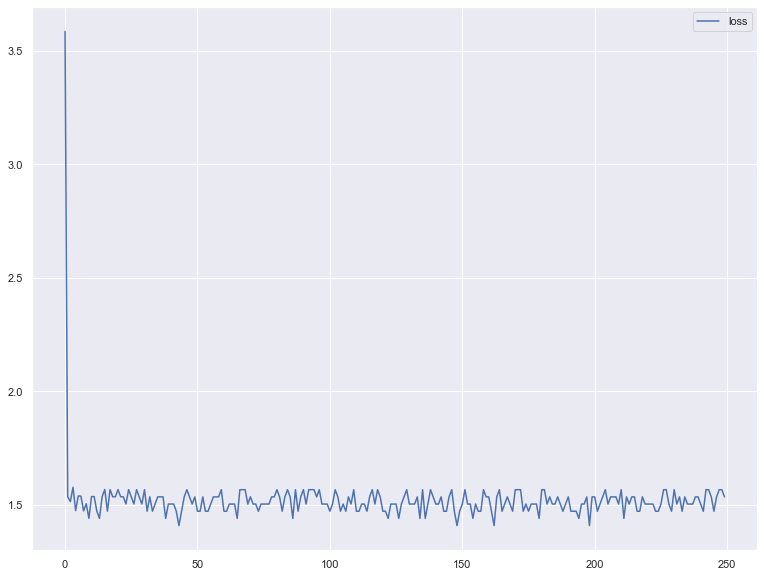

In [27]:
df = pd.DataFrame({"loss": losses})
sns.set(rc={"figure.figsize": (13, 10)})
df.plot()
None


In [22]:
def check_accuracy(loader, model):
    num_correct = 0
    num_samples = 0
    model.eval()
    res = 0
    with torch.no_grad():
        for i, (x, y) in enumerate(loader):
            x = x.to(device=device)
            y = y.to(device=device)

            pred = model(x).round()
            score_tmp = (pred[:, 0] - y[:, 0]).abs()
            res += score_tmp.sum()
    print((test_amount - res.item()) / test_amount)


check_accuracy(test_loader, model)


0.7852359208523592


In [23]:
def create_submission(valid_data, model):
    model.eval()
    preds = torch.zeros(len(valid_data.values), 1)
    with torch.no_grad():
        for i, row in enumerate(valid_data.values):
            row = torch.tensor([row], dtype=torch.float32).to(
                device=device)  # .round()
            score = model(row)
            preds[i] = score[0][0]
    return preds


preds = create_submission(valid_data, model)


In [24]:
res = preds.T.tolist()[0]


In [25]:
submission = pd.read_csv("./data/sample_submission.csv")
submission[TARGET] = res
submission[TARGET] = submission[TARGET].astype(int)
submission.head()


,id,failure
0,26570,0
1,26571,0
2,26572,0
3,26573,0
4,26574,0


In [26]:
submission[["id", TARGET]].to_csv("./data/solution.csv", index=False)
